In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from pandas.api.types import is_integer_dtype
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.augmentations import ClassificationSMOTE

plt.style.use("./auri.mplstyle")


In [2]:
df_orig = pd.read_parquet("output/data.parquet")
df_1 = df_orig[df_orig.fire == 1]
np.random.seed(1106)
df_0 = df_orig[df_orig.fire == 0].sample(n=len(df_1))
np.random.seed(1106)
df = pd.concat([df_1, df_0]).sample(frac=1).reset_index(drop=True)
df = df[
    [
        "A8",
        "A10",
        "A14",
        "A18",
        "A20",
        "gd_zone",
        "gg_zone",
        "jd_zone",
        "pr_zone",
        "si_zone",
        "crime_zone",
        "fire",
        "fire_1km_cnt",
        "fire_1km2_cnt",
        "fire_500m_cnt",
        "year",
    ]
]
np.random.seed(1106)
df["set"] = np.random.choice(
    ["train", "valid", "test"], p=[0.8, 0.1, 0.1], size=len(df)
)

train_idx = df[df.set == "train"].index
valid_idx = df[df.set == "valid"].index
test_idx = df[df.set == "test"].index

categorical_columns = ["A8", "A10", "A20", "fire"]
categorical_classes = {}
categorical_dims = {}

for col in categorical_columns:
    print(col, df[col].nunique())
    l_enc = LabelEncoder()
    l_enc.fit(df_orig[col].fillna("N_A").values)
    df[col] = df[col].fillna("N_A")
    df[col] = l_enc.transform(df[col].values)
    categorical_classes[col] = l_enc.classes_
    categorical_dims[col] = len(l_enc.classes_)

print(categorical_classes)

numerical_columns = [
    "A14",
    "A18",
    "fire_1km_cnt",
    "fire_1km2_cnt",
    "fire_500m_cnt",
    "crime_zone",
    "gd_zone",
    "gg_zone",
    "jd_zone",
    "pr_zone",
    "si_zone",
    "year",
]

df[numerical_columns] = df[numerical_columns].astype(float)
for col in numerical_columns:
    m_train = df.loc[train_idx, col].mean()
    m_valid = df.loc[valid_idx, col].mean()
    m_test = df.loc[test_idx, col].mean()
    df.loc[train_idx, col] = df.loc[train_idx, col].fillna(m_train)
    df.loc[valid_idx, col] = df.loc[valid_idx, col].fillna(m_valid)
    df.loc[test_idx, col] = df.loc[test_idx, col].fillna(m_test)

features = [col for col in df.columns if col not in ["set", "fire"]]
cat_idxs = [i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [
    categorical_dims[f] for _, f in enumerate(features) if f in categorical_columns
]

X_train = df[features].values[train_idx]
X_valid = df[features].values[valid_idx]
X_test = df[features].values[test_idx]

y_train = df["fire"].values[train_idx]
y_valid = df["fire"].values[valid_idx]
y_test = df["fire"].values[test_idx]


A8 32
A10 21
A20 2
fire 2
{'A8': array(['01000', '02000', '03000', '04000', '05000', '06000', '07000',
       '08000', '09000', '10000', '11000', '12000', '13000', '14000',
       '15000', '16000', '17000', '18000', '19000', '20000', '21000',
       '22000', '23000', '24000', '25000', '26000', '27000', '29000',
       '31000', 'N_A', 'Z3000', 'Z5000', 'Z6000', 'Z8000', 'Z9000'],
      dtype=object), 'A10': array(['10', '11', '12', '13', '19', '21', '22', '26', '29', '30', '31',
       '32', '33', '37', '39', '40', '41', '42', '43', '49', '50', '51',
       '52', '53', '61', '63', '74', '99', 'N_A'], dtype=object), 'A20': array(['N', 'N_A', 'Y'], dtype=object), 'fire': array([0, 1])}


In [3]:
df_orig = pd.read_parquet("output/data.parquet")
df2 = df_orig.loc[
    :,
    [
        "X",
        "Y",
        "A8",
        "A10",
        "A14",
        "A18",
        "A20",
        "gd_zone",
        "gg_zone",
        "jd_zone",
        "pr_zone",
        "si_zone",
        "crime_zone",
        "fire",
        "fire_1km_cnt",
        "fire_1km2_cnt",
        "fire_500m_cnt",
        "year",
    ],
]

categorical_columns = ["A8", "A10", "A20", "fire"]
categorical_classes = {}
categorical_dims = {}

for col in categorical_columns:
    print(col, df2[col].nunique())
    l_enc = LabelEncoder()
    l_enc.fit(df_orig[col].fillna("N_A").values)
    df2[col] = df2[col].fillna("N_A")
    df2[col] = l_enc.transform(df2[col].values)
    categorical_classes[col] = l_enc.classes_
    categorical_dims[col] = len(l_enc.classes_)

print(categorical_classes)

numerical_columns = [
    "A14",
    "A18",
    "fire_1km_cnt",
    "fire_1km2_cnt",
    "fire_500m_cnt",
    "crime_zone",
    "gd_zone",
    "gg_zone",
    "jd_zone",
    "pr_zone",
    "si_zone",
    "year",
]

df2[numerical_columns] = df2[numerical_columns].astype(float)
for col in numerical_columns:
    m = df2.loc[:, col].mean()
    df2.loc[:, col] = df2.loc[:, col].fillna(m)

features = [col for col in df2.columns if col not in ["X", "Y", "set", "fire"]]
cat_idxs = [i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [
    categorical_dims[f] for _, f in enumerate(features) if f in categorical_columns
]

X_all = df2[features].values
y_all = df2["fire"].values


A8 34
A10 28
A20 2
fire 2
{'A8': array(['01000', '02000', '03000', '04000', '05000', '06000', '07000',
       '08000', '09000', '10000', '11000', '12000', '13000', '14000',
       '15000', '16000', '17000', '18000', '19000', '20000', '21000',
       '22000', '23000', '24000', '25000', '26000', '27000', '29000',
       '31000', 'N_A', 'Z3000', 'Z5000', 'Z6000', 'Z8000', 'Z9000'],
      dtype=object), 'A10': array(['10', '11', '12', '13', '19', '21', '22', '26', '29', '30', '31',
       '32', '33', '37', '39', '40', '41', '42', '43', '49', '50', '51',
       '52', '53', '61', '63', '74', '99', 'N_A'], dtype=object), 'A20': array(['N', 'N_A', 'Y'], dtype=object), 'fire': array([0, 1])}


In [4]:
labels = [
    "건축물_용도",
    "건축물_구조",
    "연면적",
    "용적률",
    "위반건축물여부",
    "강도",
    "강간·강제추행",
    "절도",
    "폭력",
    "살인",
    "5대 범죄",
    "반경 1km 화재",
    "주변 1km² 화재",
    "반경 500m 화재",
    "사용승인",
]


In [5]:
loaded = np.load("output/explain.npz")


In [6]:
feature_importances_ = loaded["feature_importances_"]
explain_matrix = loaded["explain_matrix"]
masks = []
for i in range(3):
    masks.append(loaded[f"masks{i}"])


In [7]:
df_feature_importances = pd.DataFrame({"label": labels, "feature importance": feature_importances_})
df_feature_importances

,label,feature importance
0,건축물_용도,0.185353
1,건축물_구조,0.074428
2,연면적,0.256922
3,용적률,0.072999
4,위반건축물여부,0.036366
5,강도,0.002809
6,강간·강제추행,0.021338
7,절도,0.000532
8,폭력,0.001294
9,살인,0.001451


In [8]:
df_feature_importances.to_csv("output/feature_importances.csv", encoding="utf_8_sig")

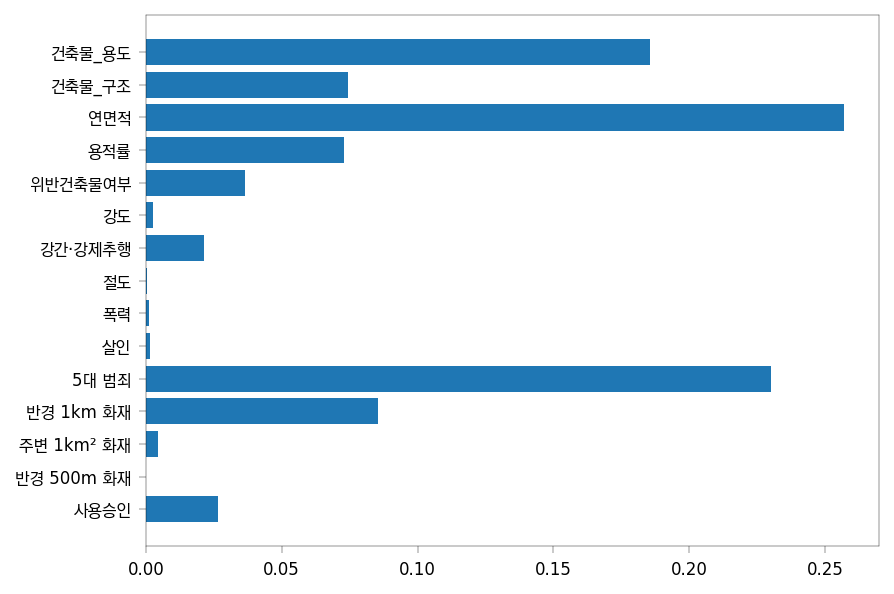

In [23]:
plt.barh(labels, feature_importances_)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("output/feature_importances.svg")
plt.savefig("output/feature_importances.png")


변수 중요도는 연면적, 5대 범죄 종합 발생률, 용도 순

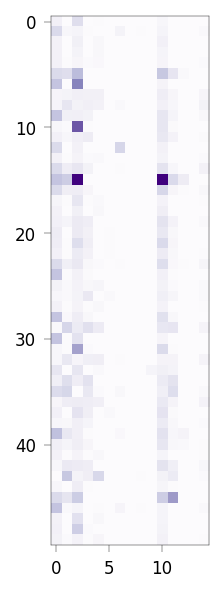

In [24]:
plt.figure(figsize=(2, 4))
plt.imshow(explain_matrix[:50], cmap="Purples")
plt.tight_layout()
plt.savefig("output/explain_matrix.svg")
plt.savefig("output/explain_matrix.png")


용도, 연면적, 5대 범죄 종합 발생률을 중심으로 다양한 변수를 고려하여 판단하고 있음.

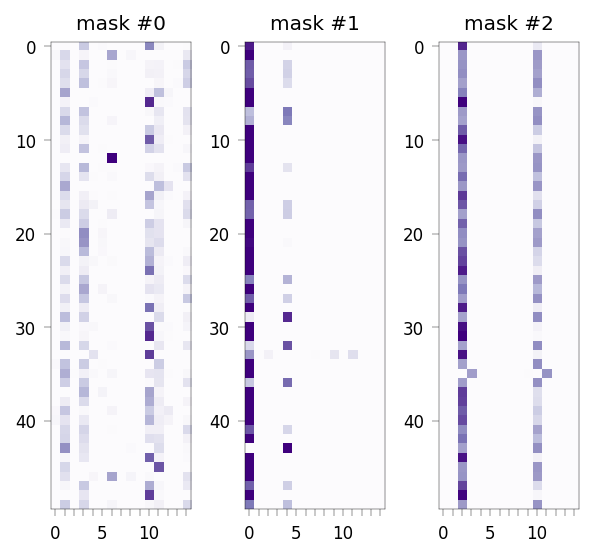

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(4, 4))

for i in range(3):
    axs[i].imshow(masks[i][:50], cmap="Purples")
    axs[i].set_title(f"mask #{i}")
    axs[i].set_xticks(range(len(features)))
    axs[i].set_xticklabels([i if i % 5 == 0 else "" for i in range(len(features))])

fig.tight_layout()

plt.savefig("output/masks.svg")
plt.savefig("output/masks.png")


각 단계에서 함께 고려하는 변수들은 서로 강한 연관이 나타나는 경우임.

첫 단계에서는 다양한 변수를 종합하여 고려하지만,
2번째 단계에서는 건축물 용도 또는 위반건축물 여부 둘 중 하나를 더 중요하게 고려함.
3번째 단계에서는 연면적과 5대 범죄 발생률을 동시에 고려함.

In [26]:
np.random.seed(1106)
df_0 = df_orig[df_orig.fire == 0].sample(n=len(df_1))
np.random.seed(1106)
df = pd.concat([df_1, df_0]).sample(frac=1).reset_index(drop=False, names="old_index")
np.random.seed(1106)
df["set"] = np.random.choice(
    ["train", "valid", "test"], p=[0.8, 0.1, 0.1], size=len(df)
)
df_test = df_orig.loc[df[df.set == "test"].old_index]
all(test_idx == df[df.set == "test"].index)


True

In [27]:
df_test["use_viol"] = masks[1][:, 0] < masks[1][:, 4]
len(df_test), df_test.use_viol.value_counts()


(3930,
 False    3499
 True      431
 Name: use_viol, dtype: int64)

시험 데이터셋에서 위반건축물 여부를 용도보다 중요한 판단 기준으로 삼는 경우는 11.0%

In [28]:
df_test.groupby(["use_viol", "A20"]).fire.mean()


use_viol  A20
False     N      0.529449
          Y      0.534050
True      N      0.286445
          Y      0.325000
Name: fire, dtype: float64

위반건축물 여부를 중요한 판단 기준으로 삼는 경우는 시험 데이터셋에서 위반건축물 여부에 따라 화재 위험도가 4%p 달라지며, 이는 그렇지 않은 경우 0.5%p 차이에 비하여 높은 수준임.


In [29]:
pv = df_test.pivot_table("fire", "use_viol", "A20", "mean")
pv = pv.rename_axis(index="2단계 판단 기준 변수", columns="위반여부")
pv = pv.rename(
    index={True: "위반여부 사용", False: "다른 변수(용도) 사용"},
    columns={"N": "미위반", "Y": "위반"},
)
pv = pv.sort_index(ascending=False)
pv.applymap(lambda x: f"{round(x*100, 1)}%")


위반여부,미위반,위반
2단계 판단 기준 변수,,
위반여부 사용,28.6%,32.5%
다른 변수(용도) 사용,52.9%,53.4%


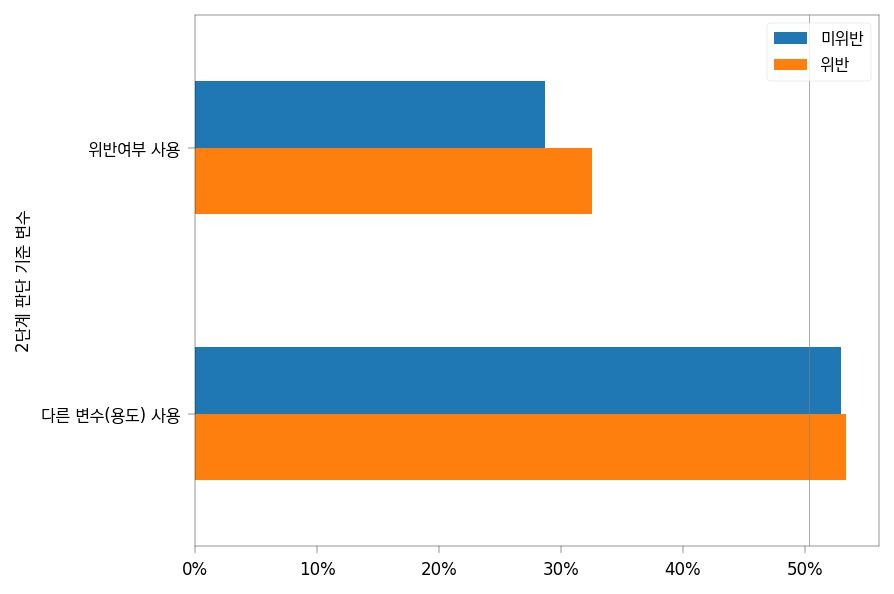

In [30]:
pv.plot.barh()
plt.axvline(df_test.fire.mean(), color='gray')
plt.legend(loc='upper right')
plt.gca().invert_yaxis()
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))

plt.tight_layout()
plt.savefig("output/viol.svg")
plt.savefig("output/viol.png")

In [31]:
df_test.fire.mean()

0.5033078880407125

빨간 선: 시험 데이터셋의 화재 발생 비율 (50.3%)


이렇게 TabNet 등 딥 러닝 모형은 심층신경망을 활용하여 최종 판단 결과에 여러 단계를 거쳐 간접적으로 영향을 미치는 복합적인 관계를 학습할 수 있음.

딥 러닝을 활용한 예측 분석의 정확도를 높이기 위해서는 간접적인 관계를 갖는 다양한 데이터를 모두 연계할 수 있는 체계를 구축할 필요가 있음.